In [1]:
from typing import Annotated

from IPython.display import display, Image
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.graph import END, StateGraph, START, MessagesState
from langchain_core.messages import convert_to_messages
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.types import Command
from langchain_tavily import TavilySearch

### Print

In [2]:
async def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return
    
    indented = "\n".join("\t" + c for c in pretty_message.split('\n'))
    print(indented)
    
    
async def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return 
        
        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True
        
    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label
        
        print(update_label)
        print("\n")
        
        messages = convert_to_messages(node_update['messages'])
        if last_message:
            messages = messages[-1:]
            
        for m in messages:
            await pretty_print_message(m, indent=is_subgraph)
        print("\n")

### Setup agent communication

In [ ]:
async def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help"
    
    @tool(name, description=description)
    async def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId]
    ) -> Command:
        tool_message = ToolCall({
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id
        })
        return Command(
            goto=agent_name,
            update={**state, "message": state['messages'] + [tool_message]},
            graph=Command.PARENT
        )
    
    return handoff_tool

In [4]:
assign_to_research_agent = await create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent."
)

assign_to_math_agent = await create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent"
)

### Worker agent

In [5]:
web_search = TavilySearch(max_results=3)

In [6]:
# web_search_results = web_search.invoke('Who is the mayor of NYC?')
# web_search_results['results'][0]["content"]

In [7]:
@tool
async def add(a: float, b: float):
    """Add two numbers"""
    return a + b

@tool
async def mulitply(a: float, b: float):
    """Multiply two numbers"""
    return a * b

@tool
async def divide(a: float, b: float):
    """Divide two numbers"""
    return a / b


    

In [8]:
async def build_math_system_prompt():
    return (
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    )

In [9]:
math_system_prompt = await build_math_system_prompt()

math_agent = create_react_agent(
    model=f"openai:gpt-4o",
    tools=[add, mulitply, divide],
    prompt=math_system_prompt,
    name="math_agent"
)

In [10]:
async def build_research_system_prompt() -> str:
    return (
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    )

In [11]:
system_prompt = await build_research_system_prompt()

research_agent = create_react_agent(
    model=f"openai:gpt-4o",
    tools=[web_search],
    prompt=system_prompt,
    name='research_agent'
)

##### Create supervisor agent

In [12]:
supervisor_prompt = (
    "You are a supervisor managing two agents:\n"
    "- a research agent. Assign research-related tasks to this agent\n"
    "- a math agent. Assign math-related tasks to this agent\n"
    "Assign work to one agent at a time, do not call agents in parallel.\n"
    "Do not do any work yourself."
)

In [13]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4o",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=supervisor_prompt,
    name='supervisor'
)

##### Create mulit agent graph

In [14]:
supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge('math_agent', 'supervisor')
    .compile()
)

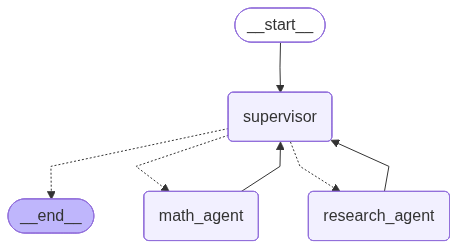

In [15]:
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [16]:
async for chunk in supervisor.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024,  what % of US GDP was New York state?"
            }
        ]
    }
):
    await pretty_print_messages(chunk, last_message=True)
    
final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_nsTgjznucwyvvfYkMSFYyPai)
 Call ID: call_nsTgjznucwyvvfYkMSFYyPai
  Args:




ValueError: Found AIMessages with tool_calls that do not have a corresponding ToolMessage. Here are the first few of those tool calls: [{'name': 'transfer_to_research_agent', 'args': {}, 'id': 'call_nsTgjznucwyvvfYkMSFYyPai', 'type': 'tool_call'}].

Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage (result of a tool invocation to return to the LLM) - this is required by most LLM providers.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CHAT_HISTORY